# Fréquence de mise à jour nécessaire

Nous pouvons dès à présent établir un système nous indiquant quand la fréquence de mise à jour nécessaire et idéale des clusters. Il suffit de mettre en place un système d'Ajusted Rand Score avec les clusters KMeans.

Commençons en chargeant notre CSV et en faisant nos imports :

In [34]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
from datetime import date, timedelta, datetime

import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as snsf

data = pd.read_csv("data/rfm_data.csv")

Maintenant, on va itérer et calculer le temps écoulé entre aujourd'hui et le nombre de jours depuis la dernière commande du client puis calculer le score ARI des commandes par mois.

In [35]:
data['order_purchase_timestamp'] = 'none'

for i, row in data.iterrows():
    data.loc[i, ['order_purchase_timestamp']] = (datetime.now() - timedelta(days=row['(days)last_purchase'])).strftime("%d/%m/%Y")

def kmean_process_date(data_period, data_init):
    kmeans = KMeans(n_clusters=5,init='k-means++').fit(data_period)
    kmeans2 = KMeans(n_clusters=5,n_init=1,init='random').fit(data_init)
    return adjusted_rand_score(kmeans2.labels_, kmeans.labels_)

all_dates = {
    "01/01/2022": "02/01/2022",
    "02/01/2022": "03/01/2022",
    "03/01/2022": "04/01/2022",
    "04/01/2022": "05/01/2022",
    "05/01/2022": "06/01/2022",
    "06/01/2022": "07/01/2022",
    "07/01/2022": "08/01/2022",
    "08/01/2022": "09/01/2022",
    "09/01/2022": "10/01/2022",
    "10/01/2022": "11/01/2022",
    "11/01/2022": "12/01/2022"
}

mesurate_ari_by_month = {}

def calculate_kmean_by_month():
    for key in all_dates:
        data_temp = pd.DataFrame({})
        start_date = key
        end_date = all_dates[key]
        for i in range(0, len(data)):
            is_in_period = datetime.strptime(start_date, "%d/%m/%Y") < datetime.strptime(data.at[i, 'order_purchase_timestamp'], '%d/%m/%Y') < datetime.strptime(end_date, "%m/%d/%Y")

            if is_in_period:
                data_var = data.loc[[i]]
                data_temp = pandas.concat([data_temp, data_var])

        data_period = pd.DataFrame({ '(days)last_purchase': data_temp['(days)last_purchase'], 'total_orders': data_temp['total_orders'], 'total_spend': data_temp['total_spend'] })
        data_init = pd.DataFrame({ '(days)last_purchase': data['(days)last_purchase'], 'total_orders': data['total_orders'], 'total_spend': data['total_spend'] })

        mesurate_ari_by_month[start_date] = kmean_process_date(data_period, data_init[0:len(data_period)])  

calculate_kmean_by_month()

Désormais, nous pouvons afficher le résultat de notre ARI sous forme de graphique :

C:\Users\elect\AppData\Local\Temp\ipykernel_17804\2546887363.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari_score.append(key_value, ignore_index=True)
C:\Users\elect\AppData\Local\Temp\ipykernel_17804\2546887363.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari_score.append(key_value, ignore_index=True)
C:\Users\elect\AppData\Local\Temp\ipykernel_17804\2546887363.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari_score.append(key_value, ignore_index=True)
C:\Users\elect\AppData\Local\Temp\ipykernel_17804\2546887363.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari

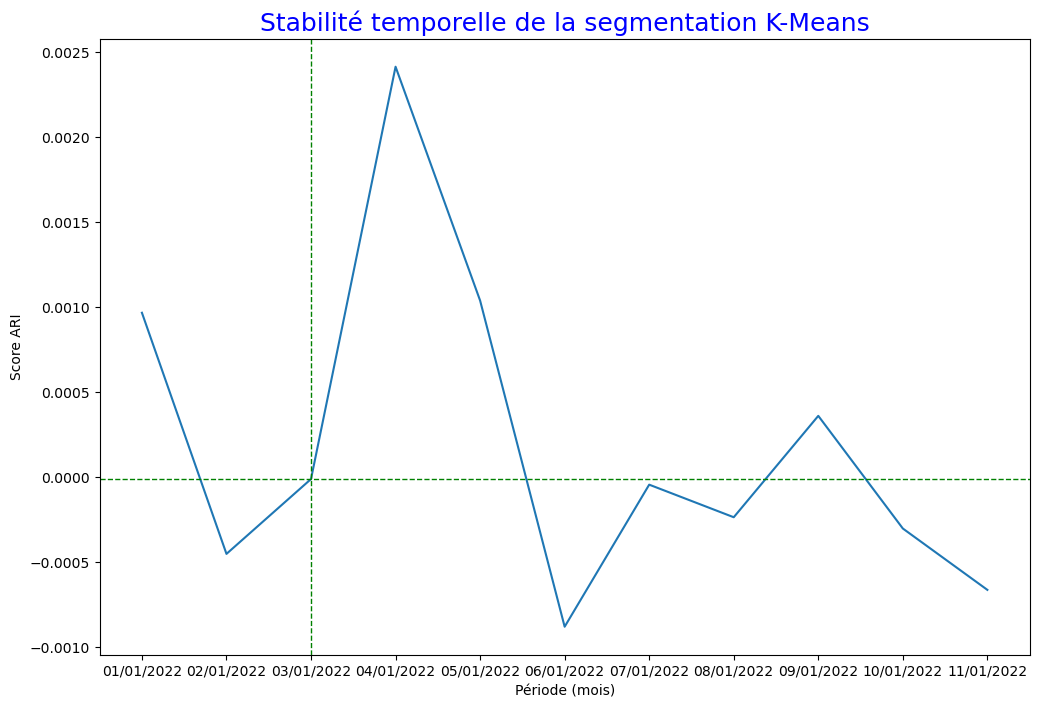

In [36]:

ari_score = pd.DataFrame({ "period": [], "ARI": [] })

for key in mesurate_ari_by_month:
    key_value = { "period": key, "ARI": mesurate_ari_by_month[key] }
    ari_score = ari_score.append(key_value, ignore_index=True)

fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="period", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--",
            color="green",
            xmax=1,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--",
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation K-Means",
          fontsize=18,
          color="b")
plt.show()

# Conclusion

On peut ainsi conclure ici que la fréquence de mise à jour idéale des clusters est tout les 3 mois.